In [1]:
from __future__ import print_function, division, absolute_import

#Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist', one_hot=True)

import tensorflow as tf
from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\train-images-idx3-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\train-labels-idx1-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\t10k-images-idx3-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\t10k-labels-idx1-ubyte.gz


Using TensorFlow backend.


In [2]:
#Training Params
learning_rate = 0.001
num_steps = 1000
batch_size = 128
display_step = 50

#Network Params
num_input = 784 #MNIST data input feature (image shape: 28*28)
num_classes = 10 #MNIST total classes (0-9)
dropout = 0.75 #Dropout, probability to keep units

#Tf Graph input
x = tf.placeholder(dtype=tf.float32, shape=[None, num_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])
keep_prob = tf.placeholder(dtype=tf.float32) #dropout rate (0.75 keep, 0.25 drop)

In [3]:
#Create layers functions
def conv2d(x, W, b, strides=1):
    #Conv2d wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1,strides,strides,1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    #Maxpool2d wrapper
    return tf.nn.max_pool(x, 
                          ksize=[1,k,k,1], 
                          strides=[1,k,k,1], 
                          padding='SAME')

In [4]:
#Store layers weights & biases
weights = {
    #5x5 conv, 1 input, 32 outputs
    'w1': tf.Variable(tf.random_normal(shape=[5,5,1,32])),
    #5x5 conv, 32 inputs, 64 outputs
    'w2': tf.Variable(tf.random_normal(shape=[5,5,32,64])),
    #fully connected, 7x7x64 inputs, 1024 outputs
    'fc': tf.Variable(tf.random_normal(shape=[7*7*64,1024])),
    #1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal(shape=[1024,num_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal(shape=[32])),
    'b2': tf.Variable(tf.random_normal(shape=[64])),
    'bfc': tf.Variable(tf.random_normal(shape=[1024])),
    'out': tf.Variable(tf.random_normal(shape=[num_classes]))
}

In [5]:
#Create model function
def conv_net(x, weights, biases, dropout):
    #MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    #Reshape to match picture format [height x width x channel]
    #Tensor input become 4-D: [Batch size, Height, Width, Channel]
    x = tf.reshape(tensor=x, shape=[-1, 28, 28, 1])
    
    #Convolution layer 1
    conv1 = conv2d(x=x, W=weights['w1'], b=biases['b1'])
    #Maxpool layer 1 (down-sampling)
    conv1 = maxpool2d(x=conv1, k=2)
    
    #Convolution layer 2
    conv2 = conv2d(x=conv1, W=weights['w2'], b=biases['b2'])
    #Maxpool layer 2 (down-sampling)
    conv2 = maxpool2d(x=conv2, k=2)
    
    #Fully connected layer
    #Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(tensor=conv2, shape=[-1, weights['fc'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['fc']), biases['bfc'])
    fc1 = tf.nn.relu(fc1)
    
    #Apply Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob=dropout)
    
    #Output layer, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return out

In [6]:
#Construct model
logits = conv_net(x, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

#Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
train_op = optimizer.minimize(loss_op)

#Evaluate model
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

#Init global variables
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
#Start training
training_loss = []

with tf.Session() as sess:
    #Run init
    sess.run(init)
    
    for step in range(1, num_steps+1):
        #Iterate to next batch
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        #Optimization op (backprop)
        sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        
        if step % display_step == 0 or step == 1:
            #Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            training_loss.append(loss)
            
            print('Step ', str(step), '\n    Minibatch Loss= {:.4f}'.format(loss), '\n    Training Accuracy= {:.4f}'.format(acc))
            
    print('-->Training Completed!!!!')
    
    #Calculate accuracy for 256 MNIST test images
    print('-->Test Accuracy: ', sess.run(accuracy, feed_dict={x: mnist.test.images[:256], 
                                                              y: mnist.test.labels[:256],
                                                              keep_prob: 1.0}))

Step  1 
    Minibatch Loss= 55921.2109 
    Training Accuracy= 0.1172
Step  50 
    Minibatch Loss= 3699.7712 
    Training Accuracy= 0.8359
Step  100 
    Minibatch Loss= 1221.5076 
    Training Accuracy= 0.9297
Step  150 
    Minibatch Loss= 1468.3538 
    Training Accuracy= 0.9219
Step  200 
    Minibatch Loss= 598.1107 
    Training Accuracy= 0.9531
Step  250 
    Minibatch Loss= 639.3346 
    Training Accuracy= 0.9453
Step  300 
    Minibatch Loss= 260.7534 
    Training Accuracy= 0.9609
Step  350 
    Minibatch Loss= 1270.9188 
    Training Accuracy= 0.9141
Step  400 
    Minibatch Loss= 691.2950 
    Training Accuracy= 0.9453
Step  450 
    Minibatch Loss= 159.2100 
    Training Accuracy= 0.9531
Step  500 
    Minibatch Loss= 428.8839 
    Training Accuracy= 0.9766
Step  550 
    Minibatch Loss= 298.8528 
    Training Accuracy= 0.9453
Step  600 
    Minibatch Loss= 232.3773 
    Training Accuracy= 0.9609
Step  650 
    Minibatch Loss= 108.1546 
    Training Accuracy= 0.9844
Ste

In [8]:
training_loss

[55921.21,
 3699.7712,
 1221.5076,
 1468.3538,
 598.1107,
 639.3346,
 260.75336,
 1270.9188,
 691.29504,
 159.20999,
 428.88394,
 298.85278,
 232.37729,
 108.15456,
 362.4687,
 420.53406,
 142.53966,
 202.69296,
 365.32495,
 55.060993,
 84.04099]

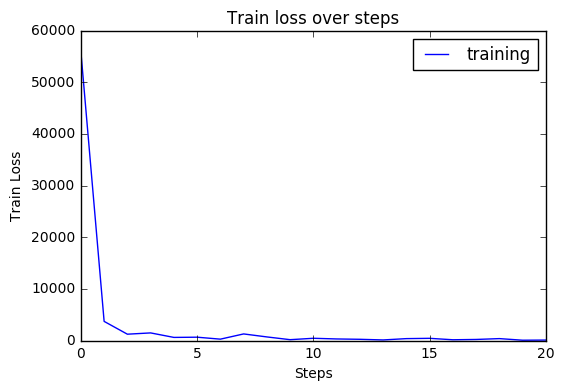

In [9]:
import matplotlib.pyplot as plt

plt.xlabel('Steps')
plt.ylabel('Train Loss')
plt.title('Train loss over steps')
plt.plot(training_loss, label='training')
plt.legend()
plt.show()